In [1]:
# Import required libraries
import sys
from pathlib import Path

# Add project root to Python path (go up two levels from notebooks/natural gas/)
project_root = Path.cwd().parent.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from core.backtest_orchestrator import BacktestOrchestrator
from signals.momentum import MomentumSignalV2
from signals.mean_reversion import MeanReversionSignal
from signals.energy_seasonal import EnergySeasonalSignal, EnergySeasonalLongOnly

# Reload modules to get latest code changes
import importlib
importlib.reload(sys.modules['core.backtest_orchestrator'])

# Configure pandas display
pd.set_option('display.max_columns', None)

pd.set_option('display.width', 120)
print(f"   Current directory: {Path.cwd()}")

pd.set_option('display.precision', 4)
print(f"   Project root: {project_root}")

print("✅ Imports successful")

   Current directory: /Users/Sakarias/QuantTrading/notebooks/natural gas
   Project root: /Users/Sakarias/QuantTrading
✅ Imports successful


# Natural Gas Trading Strategy - Statkraft Quant PM Case Study

**Recent Updates:**
- ✅ Fixed MeanReversionSignal bug (forward-fill after exit was causing positions to persist)
- ✅ Added risk manager logging to CSV files (`logs/risk_rejections_*.csv`)
- ✅ Risk logs capture: date, ticker, reason, portfolio value, attempted shares, and strategy details
- ✅ Module reload logic ensures latest code changes are used

This notebook demonstrates a **professional natural gas trading strategy** suitable for an energy trading desk at Statkraft.

## Overview

**Instruments:**
- **NG (Natural Gas)**: Primary instrument - Henry Hub natural gas futures
- **HO (Heating Oil)**: Correlated energy product - seasonal demand overlap
- **RB (RBOB Gasoline)**: Related refined product - refinery demand indicator

**Key Features:**
- Seasonality-aware strategies (winter heating demand, summer cooling)
- Mean reversion for natural gas volatility
- Momentum for sustained trends
- Energy sector benchmark (XLE) instead of SPY

**Natural Gas Market Characteristics:**
- High volatility due to weather sensitivity
- Strong seasonal patterns (winter heating, summer cooling)
- Storage constraints (limited capacity)
- Supply shocks (pipeline disruptions, weather events)
- Mean-reverting within long-term trends

Define portfolio-level settings for an energy trading desk.

---

## 1. Portfolio Configuration

In [2]:
# Portfolio Configuration - Energy Trading Desk
CONFIG = {
    'assets': ['NG', 'HO', 'RB'],  # Natural Gas, Heating Oil, RBOB Gasoline
    'total_capital': 1_000_000,  # $1M portfolio (typical for energy desk)
    'oos_split': 0.25,  # 75% train, 25% out-of-sample
    'date_range': ('2015-01-01', '2024-12-31'),  # 10 years of data
    'use_futures_sizing': True  # Use integer contract sizing for futures
}

# Futures contract specifications for energy products
CONTRACT_SPECS = {
    'NG': {
        'multiplier': 10_000,  # 10,000 MMBtu per contract
        'tick_size': 0.001,     # $0.001 per MMBtu = $10 per contract
        'margin': 5_000,        # Approximate margin requirement
        'description': 'Henry Hub Natural Gas Futures'
    },
    'HO': {
        'multiplier': 42_000,  # 42,000 gallons (1,000 barrels)
        'tick_size': 0.0001,    # $0.0001 per gallon = $4.20 per contract
        'margin': 6_000,
        'description': 'NY Harbor Heating Oil Futures'
    },
    'RB': {
        'multiplier': 42_000,  # 42,000 gallons (1,000 barrels)
        'tick_size': 0.0001,    # $0.0001 per gallon = $4.20 per contract
        'margin': 7_000,
        'description': 'RBOB Gasoline Futures'
    }
}

print("📋 Statkraft Energy Trading Portfolio Configuration:")
print(f"   Assets: {CONFIG['assets']}")
for ticker in CONFIG['assets']:
    spec = CONTRACT_SPECS[ticker]
    print(f"      - {ticker}: {spec['description']}")
    print(f"        Contract Size: {spec['multiplier']:,} units")
    print(f"        Margin: ${spec['margin']:,}")
print(f"\n   Total Capital: ${CONFIG['total_capital']:,}")
print(f"   Train/Test Split: {(1-CONFIG['oos_split'])*100:.0f}% / {CONFIG['oos_split']*100:.0f}%")
print(f"   Date Range: {CONFIG['date_range'][0]} to {CONFIG['date_range'][1]}")

📋 Statkraft Energy Trading Portfolio Configuration:
   Assets: ['NG', 'HO', 'RB']
      - NG: Henry Hub Natural Gas Futures
        Contract Size: 10,000 units
        Margin: $5,000
      - HO: NY Harbor Heating Oil Futures
        Contract Size: 42,000 units
        Margin: $6,000
      - RB: RBOB Gasoline Futures
        Contract Size: 42,000 units
        Margin: $7,000

   Total Capital: $1,000,000
   Train/Test Split: 75% / 25%
   Date Range: 2015-01-01 to 2024-12-31


## 2. Initialize Orchestrator & Load Data

Create the orchestrator with our config and load price data.

In [3]:
# Initialize orchestrator with config
orchestrator = BacktestOrchestrator(config=CONFIG)

# Load energy market data
orchestrator.load_data(
    tickers=CONFIG['assets'],
    start_date=CONFIG['date_range'][0],
    end_date=CONFIG['date_range'][1],
    use_yfinance=True,
    verbose=True
)

# Load Energy Sector ETF (XLE) as benchmark instead of SPY
# XLE tracks the energy sector and is more relevant for natural gas trading
orchestrator.load_benchmark('XLE', verbose=True)

print("\n✅ Data loaded successfully!")
print(f"   Natural Gas (NG): {len(orchestrator.prices['NG'])} trading days")
print(f"   Heating Oil (HO): {len(orchestrator.prices['HO'])} trading days")
print(f"   Gasoline (RB): {len(orchestrator.prices['RB'])} trading days")
print(f"   Benchmark (XLE): {len(orchestrator.benchmark_data)} trading days")

📊 Loading data for 3 assets...

Loading 3 assets: ['NG', 'HO', 'RB']
  NG: Fetching from yfinance (no CSV file)
  ✅ NG: Fetched 2751 rows from 2015-01-02 to 2025-12-08
✓ NG: 2751 rows, 2015-01-02 to 2025-12-08
  HO: Fetching from yfinance (no CSV file)
  ✅ NG: Fetched 2751 rows from 2015-01-02 to 2025-12-08
✓ NG: 2751 rows, 2015-01-02 to 2025-12-08
  HO: Fetching from yfinance (no CSV file)
  ✅ HO: Fetched 2751 rows from 2015-01-02 to 2025-12-08
✓ HO: 2751 rows, 2015-01-02 to 2025-12-08
  RB: Fetching from yfinance (no CSV file)
  ✅ RB: Fetched 2751 rows from 2015-01-02 to 2025-12-08
✓ RB: 2751 rows, 2015-01-02 to 2025-12-08

Common date range: 2015-01-02 to 2025-12-08
Filtered date range: 2015-01-02 to 2024-12-31

Total unique dates: 2515

ALIGNMENT SUMMARY
NG: 2515/2515 valid dates (100.0%)
HO: 2515/2515 valid dates (100.0%)
RB: 2515/2515 valid dates (100.0%)

✅ Data loaded successfully:
   NG: 2515 days (2015-01-02 to 2024-12-31)
      Price range: $1.48 - $9.68
   HO: 2515 days (20

## 3. Split Train/Test Data

Split data into in-sample (train) and out-of-sample (test) periods.
This is crucial for preventing overfitting!

The split uses the `oos_split` percentage from CONFIG.

In [4]:
# Split data: 75% train, 25% OOS
orchestrator.split_train_test_data(verbose=True)

print("\n📊 Data split complete!")
print(f"   In-sample: {len(orchestrator.prices_train['NG'])} days")
print(f"   Out-of-sample: {len(orchestrator.prices_test['NG'])} days")


📊 Splitting data: 75% train, 25% OOS
  NG: 1886 train days, 629 test days
      Train: 2015-01-02 to 2022-07-01
      Test:  2022-07-05 to 2024-12-31
  HO: 1886 train days, 629 test days
      Train: 2015-01-02 to 2022-07-01
      Test:  2022-07-05 to 2024-12-31
  RB: 1886 train days, 629 test days
      Train: 2015-01-02 to 2022-07-01
      Test:  2022-07-05 to 2024-12-31
✅ Data split complete. Use .prices for train, .prices_test for OOS

📊 Data split complete!
   In-sample: 1886 days
   Out-of-sample: 629 days


In [5]:
# Analyze Natural Gas characteristics
ng_data = orchestrator.prices_train['NG'].copy()

# Calculate key statistics
ng_returns = ng_data['Close'].pct_change()
ng_volatility = ng_returns.std() * np.sqrt(252)  # Annualized volatility
ng_mean_return = ng_returns.mean() * 252  # Annualized return

# Seasonality analysis: Average returns by month
ng_data['Month'] = pd.to_datetime(ng_data.index).month
monthly_returns = ng_data.groupby('Month').apply(
    lambda x: x['Close'].pct_change().mean() * 21  # Monthly average
)

print("📊 Natural Gas Market Characteristics (In-Sample):")
print(f"   Annualized Return: {ng_mean_return:.2%}")
print(f"   Annualized Volatility: {ng_volatility:.2%}")
print(f"   Sharpe Ratio (approx): {ng_mean_return / ng_volatility:.2f}")
print(f"\n   ⚠️  High volatility commodity - perfect for mean reversion!")
print(f"\n🌡️  Seasonal Patterns (Average Monthly Returns):")
for month in range(1, 13):
    month_name = pd.to_datetime(f'2020-{month:02d}-01').strftime('%B')
    ret = monthly_returns.get(month, 0)
    emoji = "🔥" if month in [12, 1, 2] else "❄️" if month in [6, 7, 8] else "🍂"
    print(f"   {emoji} {month_name:>9}: {ret:+.2%}")

# Calculate correlation with other energy products
print("\n🔗 Correlation with Other Energy Products:")
for ticker in ['HO', 'RB']:
    if ticker in orchestrator.prices_train:
        corr = ng_data['Close'].pct_change().corr(
            orchestrator.prices_train[ticker]['Close'].pct_change()
        )
        print(f"   NG vs {ticker}: {corr:.3f}")

📊 Natural Gas Market Characteristics (In-Sample):
   Annualized Return: 24.74%
   Annualized Volatility: 57.22%
   Sharpe Ratio (approx): 0.43

   ⚠️  High volatility commodity - perfect for mean reversion!

🌡️  Seasonal Patterns (Average Monthly Returns):
   🔥   January: +13.32%
   🔥  February: +17.50%
   🍂     March: +16.55%
   🍂     April: +21.47%
   🍂       May: +25.26%
   ❄️      June: +19.49%
   ❄️      July: +17.46%
   ❄️    August: +8.68%
   🍂 September: +16.69%
   🍂   October: +15.82%
   🍂  November: +18.95%
   🔥  December: +15.36%

🔗 Correlation with Other Energy Products:
   NG vs HO: 0.111
   NG vs RB: 0.102


### Additional Data Sources for Natural Gas Trading

For a comprehensive natural gas trading strategy, consider these additional Yahoo Finance tickers:

**Energy Sector Indicators:**
- `XLE` - Energy Select Sector SPDR (benchmark)
- `UNG` - United States Natural Gas Fund (NG ETF)
- `BOIL` - ProShares Ultra Bloomberg Natural Gas (2x leveraged)
- `KOLD` - ProShares UltraShort Bloomberg Natural Gas (2x inverse)

**Related Energy Commodities:**
- `CL=F` - Crude Oil Futures (energy complex correlation)
- `HO=F` - Heating Oil Futures (heating demand)
- `RB=F` - RBOB Gasoline Futures (transportation demand)

**Power & Utilities:**
- `XLU` - Utilities Select Sector SPDR (electricity demand)
- `NEE` - NextEra Energy (renewable power generation)

**Weather-Related Proxies:**
- Not directly available on Yahoo Finance, but consider:
  - NOAA Climate Prediction Center data (external API)
  - Historical degree days data
  - EIA storage reports (weekly)

For this backtest, we'll use **NG, HO, RB** as primary instruments and **XLE** as benchmark.

## 3.5. Natural Gas Market Analysis

Before defining strategies, let's analyze natural gas market characteristics.

## 4. Define Energy Trading Strategies

We'll implement **seasonally-aware hybrid strategies** that combine:
1. **Mean reversion** (high volatility regime)
2. **Momentum** (low volatility regime)  
3. **Seasonality filters** (align with natural gas demand cycles)

### Energy Seasonal Signal Features:

**Regime Detection:**
- High volatility (>24% annualized) → Mean reversion strategy
- Low volatility → Momentum strategy

**Seasonal Biases:**
- **Winter (Nov-Mar)**: +0.6 bullish bias (heating demand)
- **Summer (Jun-Aug)**: +0.3 bullish bias (power generation)
- **Shoulder (Apr-May, Sep-Oct)**: -0.2 bearish bias (low demand)

**Signal Filtering:**
- Long signals favored in winter/summer (high demand)
- Short signals favored in shoulder seasons (low demand)
- Only trades aligned with seasonal patterns are executed

### Portfolio Allocation:

**Strategy 1: NG Seasonal Long-Short (40%)**
- Primary natural gas strategy with full seasonal logic
- Supports both long and short positions
- Aggressive mean reversion parameters

**Strategy 2: HO Seasonal Long-Only (30%)**  
- Heating oil with seasonal awareness
- Long-only (no shorting)
- Moderate parameters

**Strategy 3: RB Seasonal Long-Only (30%)**
- Gasoline with seasonal awareness
- Long-only (no shorting)
- Moderate parameters

---

### Add Strategies to Orchestrator

In [6]:
# Strategy 1: Natural Gas Seasonal (Long/Short) - Primary Strategy
orchestrator.add_strategy(
    name='NG_Seasonal_LongShort',
    signal_generator=EnergySeasonalSignal(
        vol_window=30,           # 30-day volatility regime detection
        vol_threshold=0.015,     # 24% annualized vol threshold
        mr_window=20,            # 20-day mean reversion window
        mr_entry_z=2.0,          # Enter at 2σ extremes
        mr_exit_z=0.5,           # Exit when reverting
        mom_lookback=60,         # 60-day momentum (quarterly)
        mom_threshold=0.02,      # 2% threshold
        use_seasonality=True,    # Enable seasonal filtering
        winter_bias=0.6,         # Strong bullish bias in winter
        summer_bias=0.3,         # Moderate bullish in summer  
        shoulder_bias=-0.2       # Slight bearish in shoulder
    ),
    assets=['NG'],
    capital_pct=0.40,            # 40% of portfolio
    max_position_pct=0.25,       # Max 25% per position
    position_sizer_type='futures',
    position_sizer_params={'contract_multipliers': CONTRACT_SPECS},
    risk_per_trade=0.03          # 3% risk (volatile commodity)
)

# Strategy 2: Heating Oil Seasonal (Long-Only)
orchestrator.add_strategy(
    name='HO_Seasonal_LongOnly',
    signal_generator=EnergySeasonalLongOnly(
        vol_window=30,
        vol_threshold=0.012,     # Slightly lower vol threshold for HO
        mr_window=20,
        mr_entry_z=2.0,
        mr_exit_z=0.5,
        mom_lookback=60,
        mom_threshold=0.02,
        use_seasonality=True,
        winter_bias=0.7,         # Very bullish in winter (heating demand!)
        summer_bias=0.2,         # Slight bullish in summer
        shoulder_bias=-0.1       # Slight bearish in shoulder
    ),
    assets=['HO'],
    capital_pct=0.30,            # 30% of portfolio
    max_position_pct=0.25,
    position_sizer_type='atr',
    position_sizer_params={'atr_window': 14, 'atr_multiplier': 2.0},
    risk_per_trade=0.02
)

# Strategy 3: Gasoline Seasonal (Long-Only)
orchestrator.add_strategy(
    name='RB_Seasonal_LongOnly',
    signal_generator=EnergySeasonalLongOnly(
        vol_window=30,
        vol_threshold=0.012,
        mr_window=20,
        mr_entry_z=2.0,
        mr_exit_z=0.5,
        mom_lookback=60,
        mom_threshold=0.02,
        use_seasonality=True,
        winter_bias=0.1,         # Slight bullish in winter
        summer_bias=0.5,         # Strong bullish in summer (driving season!)
        shoulder_bias=0.0        # Neutral in shoulder
    ),
    assets=['RB'],
    capital_pct=0.30,            # 30% of portfolio
    max_position_pct=0.25,
    position_sizer_type='atr',
    position_sizer_params={'atr_window': 14, 'atr_multiplier': 2.0},
    risk_per_trade=0.02
)

print("\n✅ Strategies configured with seasonal awareness!")
print(f"   Total allocation: {40+30+30}% (must equal 100%)")
print("\n📊 Strategy Summary:")
print("   1. NG Seasonal Long/Short: 40% (hybrid with seasonality)")
print("      - Winter: Bullish bias (+0.6)")
print("      - Summer: Moderate bullish (+0.3)")
print("      - Shoulder: Bearish bias (-0.2)")
print("\n   2. HO Seasonal Long-Only: 30% (heating demand focus)")
print("      - Winter: Very bullish (+0.7) - heating season!")
print("      - Summer: Slight bullish (+0.2)")
print("      - Shoulder: Slight bearish (-0.1)")
print("\n   3. RB Seasonal Long-Only: 30% (driving season focus)")
print("      - Winter: Slight bullish (+0.1)")
print("      - Summer: Strong bullish (+0.5) - driving season!")
print("      - Shoulder: Neutral (0.0)")



✅ Strategies configured with seasonal awareness!
   Total allocation: 100% (must equal 100%)

📊 Strategy Summary:
   1. NG Seasonal Long/Short: 40% (hybrid with seasonality)
      - Winter: Bullish bias (+0.6)
      - Summer: Moderate bullish (+0.3)
      - Shoulder: Bearish bias (-0.2)

   2. HO Seasonal Long-Only: 30% (heating demand focus)
      - Winter: Very bullish (+0.7) - heating season!
      - Summer: Slight bullish (+0.2)
      - Shoulder: Slight bearish (-0.1)

   3. RB Seasonal Long-Only: 30% (driving season focus)
      - Winter: Slight bullish (+0.1)
      - Summer: Strong bullish (+0.5) - driving season!
      - Shoulder: Neutral (0.0)


## 5. Generate Signals (In-Sample)

Generate trading signals on the training data.

In [7]:
# Generate signals for all strategies
orchestrator.generate_signals(verbose=True)


🎯 Generating signals for 3 strategies...

  NG_Seasonal_LongShort (EnergySeasonalSignal):
    NG: 16.1% long, 15.3% short, 68.6% flat

  HO_Seasonal_LongOnly (EnergySeasonalLongOnly):
    NG: 16.1% long, 15.3% short, 68.6% flat

  HO_Seasonal_LongOnly (EnergySeasonalLongOnly):
    HO: 17.0% long, 0.0% short, 83.0% flat

  RB_Seasonal_LongOnly (EnergySeasonalLongOnly):
    RB: 17.8% long, 0.0% short, 82.2% flat

✅ Signals generated successfully
    HO: 17.0% long, 0.0% short, 83.0% flat

  RB_Seasonal_LongOnly (EnergySeasonalLongOnly):
    RB: 17.8% long, 0.0% short, 82.2% flat

✅ Signals generated successfully


In [8]:
# Analyze seasonal signal characteristics
print("\n🔍 Seasonal Signal Analysis:")
print("="*80)

for strategy_data in orchestrator.strategies:
    name = strategy_data.name
    asset = strategy_data.assets[0]
    signals = orchestrator.signals[name][asset]
    
    print(f"\n📊 {name} ({asset}):")
    print(f"   Total days: {len(signals)}")
    
    # Signal distribution
    signal_counts = signals['Signal'].value_counts().sort_index()
    print(f"\n   Overall Signal Distribution:")
    for sig_val, count in signal_counts.items():
        pct = count / len(signals) * 100
        sig_name = {-1: 'SHORT', 0: 'FLAT', 1: 'LONG'}.get(sig_val, sig_val)
        print(f"      {sig_name:>5}: {count:>4} days ({pct:>5.1f}%)")
    
    # Seasonal breakdown
    if 'Season' in signals.columns:
        print(f"\n   Signals by Season:")
        for season in ['Winter', 'Summer', 'Shoulder']:
            season_data = signals[signals['Season'] == season]
            if len(season_data) > 0:
                long_pct = (season_data['Signal'] == 1).sum() / len(season_data) * 100
                short_pct = (season_data['Signal'] == -1).sum() / len(season_data) * 100
                flat_pct = (season_data['Signal'] == 0).sum() / len(season_data) * 100
                bias = season_data['Seasonal_Bias'].iloc[0]
                
                season_emoji = {'Winter': '❄️', 'Summer': '☀️', 'Shoulder': '🍂'}[season]
                print(f"      {season_emoji} {season:>8} (bias: {bias:+.1f}): "
                      f"{long_pct:.1f}% LONG, {short_pct:.1f}% SHORT, {flat_pct:.1f}% FLAT")
    
    # Regime distribution
    if 'HighVol' in signals.columns:
        high_vol_pct = signals['HighVol'].sum() / len(signals) * 100
        print(f"\n   Volatility Regime:")
        print(f"      High Vol: {high_vol_pct:.1f}% (uses mean reversion)")
        print(f"      Low Vol:  {100-high_vol_pct:.1f}% (uses momentum)")

print("\n" + "="*80)


🔍 Seasonal Signal Analysis:

📊 NG_Seasonal_LongShort (NG):
   Total days: 1886

   Overall Signal Distribution:
      SHORT:  289 days ( 15.3%)
       FLAT: 1294 days ( 68.6%)
       LONG:  303 days ( 16.1%)

   Signals by Season:
      ❄️   Winter (bias: +0.6): 18.8% LONG, 0.0% SHORT, 81.2% FLAT
      ☀️   Summer (bias: +0.3): 18.3% LONG, 24.6% SHORT, 57.1% FLAT
      🍂 Shoulder (bias: -0.2): 11.0% LONG, 27.3% SHORT, 61.7% FLAT

   Volatility Regime:
      High Vol: 98.4% (uses mean reversion)
      Low Vol:  1.6% (uses momentum)

📊 HO_Seasonal_LongOnly (HO):
   Total days: 1886

   Overall Signal Distribution:
       FLAT: 1566 days ( 83.0%)
       LONG:  320 days ( 17.0%)

   Signals by Season:
      ❄️   Winter (bias: +0.7): 25.4% LONG, 0.0% SHORT, 74.6% FLAT
      ☀️   Summer (bias: +0.2): 16.8% LONG, 0.0% SHORT, 83.2% FLAT
      🍂 Shoulder (bias: -0.1): 6.7% LONG, 0.0% SHORT, 93.3% FLAT

   Volatility Regime:
      High Vol: 98.4% (uses mean reversion)
      Low Vol:  1.6% (uses

### 🎯 Why Energy Seasonal Signals Work

The `EnergySeasonalSignal` combines three powerful concepts:

**1. Regime-Based Strategy Selection** 🌡️
- **High Volatility** → Mean reversion (buy dips, sell rips)
  - Natural gas volatility spikes during weather extremes
  - Prices snap back after extreme moves
- **Low Volatility** → Momentum (trend following)
  - Sustained trends during stable supply/demand
  - Captures quarterly price movements

**2. Fundamental Seasonality** 📅
- **Winter (Nov-Mar)**: Bullish bias
  - Heating demand drives prices up
  - Cold snaps create supply shocks
  - Storage withdrawals accelerate
- **Summer (Jun-Aug)**: Moderately bullish
  - Power generation demand (cooling)
  - Less extreme than winter
- **Shoulder Seasons (Apr-May, Sep-Oct)**: Bearish/neutral
  - Low demand periods
  - Storage injections
  - Mean reversion opportunities

**3. Commodity-Specific Logic** ⚡
- **Natural Gas**: Balanced long/short (40% capital)
  - Most volatile, supports both directions
  - Strong seasonal patterns
- **Heating Oil**: Long-only, winter-focused (30% capital)
  - Peak demand in winter (+0.7 bias)
  - Heating season is key driver
- **Gasoline**: Long-only, summer-focused (30% capital)
  - Peak demand in summer (+0.5 bias)
  - "Driving season" phenomenon

**Advantages for Statkraft:**
- ✅ Aligns with physical market fundamentals
- ✅ Reduces false signals during off-peak seasons
- ✅ Captures regime changes (volatility-driven)
- ✅ Professional approach combining quant + fundamental

---

## 6. Run In-Sample Backtests

Execute backtests on the training period.

**Note:** Risk blocking logs will be saved to `logs/risk_rejections_*.csv` files if any trades are rejected by the risk manager.

In [ ]:
# Run backtests with risk logging
results = orchestrator.run_backtests(verbose=True)

# Check if any trades were blocked
import os
risk_logs_found = False
for strategy in orchestrator.strategies:
    risk_log_path = f'logs/risk_rejections_{strategy.name}.csv'
    if os.path.exists(risk_log_path):
        risk_log = pd.read_csv(risk_log_path)
        if len(risk_log) > 0:
            risk_logs_found = True
            print(f"\n⚠️  {strategy.name}: {len(risk_log)} trades blocked by risk manager")
            print(f"   See {risk_log_path} for details")

if not risk_logs_found:
    print("\n✅ No trades blocked by risk manager")


🔄 Running backtests for 3 strategies...

  NG_Seasonal_LongShort ($400,000.0)...
    ✅ Total Return: 4.71%
    📊 Sharpe: -0.24
    📉 Max DD: -8.30%

  HO_Seasonal_LongOnly ($300,000.0)...
    ✅ Total Return: -4.21%
    📊 Sharpe: -0.53
    📉 Max DD: -17.50%

  RB_Seasonal_LongOnly ($300,000.0)...
    ✅ Total Return: 4.32%
    📊 Sharpe: -0.23
    📉 Max DD: -18.92%

✅ All backtests completed successfully

✅ No trades blocked by risk manager


NameError: name 'risk_log_path' is not defined

## 7. In-Sample Results

View detailed results for the training period.

In [ ]:
# Print formatted summary
orchestrator.print_summary()


📊 BACKTEST SUMMARY
             Strategy   Capital Assets  Final Value  Total Return  CAGR  Sharpe  Max Drawdown  Win Rate  Total Trades
NG_Seasonal_LongShort 400000.00     NG    417634.67          0.04  0.01   -0.24         -0.08      0.61            28
 HO_Seasonal_LongOnly 300000.00     HO    286374.34         -0.05 -0.01   -0.54         -0.18      0.56            34
 RB_Seasonal_LongOnly 300000.00     RB    311896.51          0.04  0.01   -0.24         -0.19      0.65            34

----------------------------------------------------------------------------------------------------
Portfolio Total Capital: $1,000,000
Portfolio Final Value:   $1,015,906
Portfolio Return:        1.59%


## 8. Visualize In-Sample Performance

Plot equity curves and benchmark comparison.

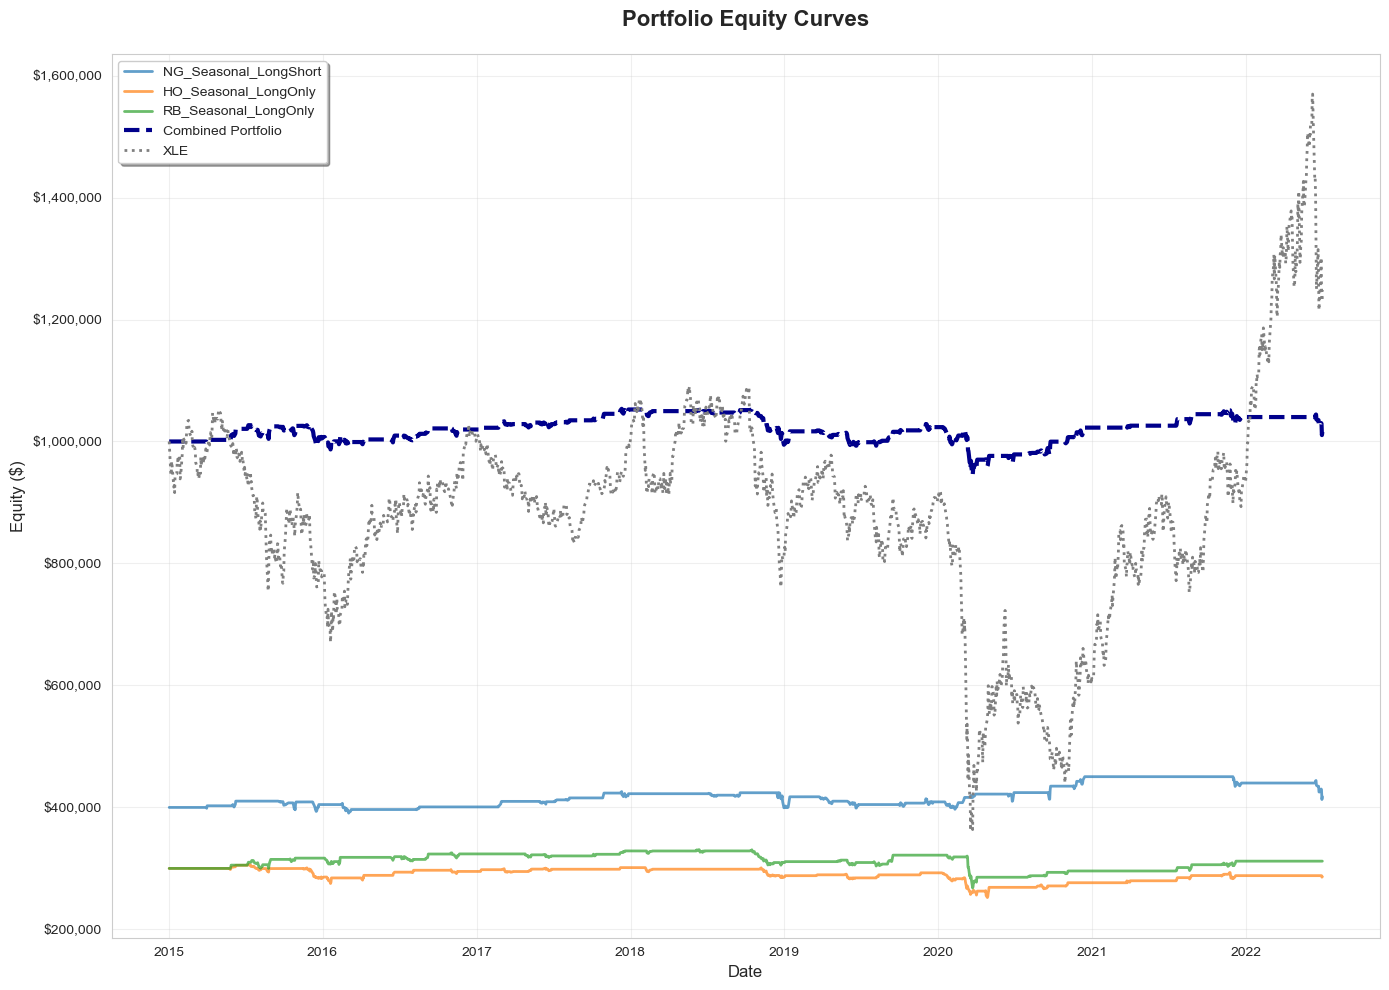

In [ ]:
# Plot equity curves
orchestrator.plot_results(
    show_individual=True,
    show_benchmark=True,
    figsize=(14, 10)
)
plt.show()

## 9. Out-of-Sample Validation 🎯

Now test on the held-out OOS data to validate the strategy.
This is the TRUE test of whether the strategy will work in live trading!

**Note:** Risk blocking logs will be saved to `logs/risk_rejections_*_OOS.csv` if any trades are rejected.

In [ ]:
# Run OOS backtest with risk logging
oos_results = orchestrator.run_oos_backtest(verbose=True)

# Check if any trades were blocked in OOS
risk_logs_found_oos = False
for strategy in orchestrator.strategies:
    risk_log_path = f'logs/risk_rejections_{strategy.name}_OOS.csv'
    if os.path.exists(risk_log_path):
        risk_log_oos = pd.read_csv(risk_log_path)
        if len(risk_log_oos) > 0:
            risk_logs_found_oos = True
            print(f"\n⚠️  {strategy.name}: {len(risk_log_oos)} trades blocked in OOS")
            print(f"   See {risk_log_path} for details")

if not risk_logs_found_oos:
    print("\n✅ No trades blocked by risk manager in OOS")

print("\n" + "="*80)
print("📊 OUT-OF-SAMPLE COMPARISON")
print("="*80)

# Compare In-Sample vs OOS
for name in orchestrator.results.keys():
    is_result = orchestrator.results[name]['result']
    oos_result = orchestrator.oos_results[name]['result']
    
    print(f"\n{name}:")
    print(f"   In-Sample Return:  {is_result.total_return:>8.2%}")
    print(f"   OOS Return:        {oos_result.total_return:>8.2%}")
    print(f"   ")
    print(f"   In-Sample Sharpe:  {is_result.metrics['Sharpe Ratio']:>8.2f}")
    print(f"   OOS Sharpe:        {oos_result.metrics['Sharpe Ratio']:>8.2f}")
    print(f"   ")
    print(f"   In-Sample Max DD:  {is_result.metrics['Max Drawdown']:>8.2%}")
    print(f"   OOS Max DD:        {oos_result.metrics['Max Drawdown']:>8.2%}")

print("\n" + "="*80)


🎯 Running OUT-OF-SAMPLE backtests...

  NG_Seasonal_LongShort - Generating OOS signals...

  HO_Seasonal_LongOnly - Generating OOS signals...

  RB_Seasonal_LongOnly - Generating OOS signals...

  NG_Seasonal_LongShort ($400,000.0)...
    ✅ OOS Return: 11.56%
    📊 OOS Sharpe: 0.36
    📉 OOS Max DD: -6.29%

  HO_Seasonal_LongOnly ($300,000.0)...
    ✅ OOS Return: 4.75%
    📊 OOS Sharpe: -0.02
    📉 OOS Max DD: -3.19%

  RB_Seasonal_LongOnly ($300,000.0)...
    ✅ OOS Return: 2.95%
    📊 OOS Sharpe: -0.23
    📉 OOS Max DD: -4.66%

✅ OOS backtests completed

📊 OUT-OF-SAMPLE COMPARISON

NG_Seasonal_LongShort:
   In-Sample Return:     4.41%
   OOS Return:          11.56%
   
   In-Sample Sharpe:     -0.24
   OOS Sharpe:            0.36
   
   In-Sample Max DD:    -8.32%
   OOS Max DD:          -6.29%

HO_Seasonal_LongOnly:
   In-Sample Return:    -4.54%
   OOS Return:           4.75%
   
   In-Sample Sharpe:     -0.54
   OOS Sharpe:           -0.02
   
   In-Sample Max DD:   -17.68%
   OOS

## 10. Export Comprehensive HTML Reports

Generate professional HTML reports with all visualizations.

In [ ]:
# Generate comprehensive HTML reports with one simple method call
report_paths = orchestrator.generate_comprehensive_reports(
    output_dir='results/html',
    benchmark_name='XLE',
    title='Natural Gas Trading Strategy - Statkraft PM Case Study',
    auto_open=True
)

# The method returns paths to all generated reports
print(f"\n📁 Report files:")
print(f"   Multi-Strategy: {report_paths['multi_strategy']}")
print(f"   Risk Dashboard: {report_paths['risk_dashboard']}")
print(f"   Individual Reports:")
for strategy_name, path in report_paths['individual'].items():
    print(f"      - {strategy_name}: {path}")

📊 Generating comprehensive HTML reports...

📊 Data alignment:
   Strategy period: 2015-01-02 to 2022-07-01
   Portfolio initial capital: $1,000,000
   Benchmark initial value: $1,000,000
   Benchmark filtered: 1888 days (from 2515 total)
   Combined equity: 1886 days

1️⃣  Generating Multi-Strategy Report...
🔍 DEBUG _generate_main_chart called with 3 strategies
  NG_Seasonal_LongShort: 400000.00 → 417634.67
  HO_Seasonal_LongOnly: 300000.00 → 286374.34
  RB_Seasonal_LongOnly: 300000.00 → 311896.51
🔍 DEBUG Figure has 5 traces:
  Trace 0 (NG_Seasonal_LongShort): y[0]=400000.00, y[-1]=417634.67, len=1886
  Trace 1 (HO_Seasonal_LongOnly): y[0]=300000.00, y[-1]=286374.34, len=1886
  Trace 2 (RB_Seasonal_LongOnly): y[0]=300000.00, y[-1]=311896.51, len=1886
  Trace 3 (Combined Portfolio): y[0]=1000000.00, y[-1]=1015905.52, len=1886
  Trace 4 (XLE): y[0]=1000000.00, y[-1]=1248361.88, len=1888
   ✅ Saved: /Users/Sakarias/QuantTrading/notebooks/natural_gas/results/html/multi_strategy_report_2025

True

In [ ]:
# Debug: Check benchmark data structure
print("🔍 Benchmark Data Debug:")
print(f"\nBenchmark data type: {type(orchestrator.benchmark_data)}")
print(f"Benchmark data shape: {orchestrator.benchmark_data.shape}")
print(f"\nBenchmark columns: {orchestrator.benchmark_data.columns.tolist()}")
print(f"\nFirst few rows:")
print(orchestrator.benchmark_data.head())
print(f"\nLast few rows:")
print(orchestrator.benchmark_data.tail())
print(f"\nBenchmark date range: {orchestrator.benchmark_data.index[0]} to {orchestrator.benchmark_data.index[-1]}")

print(f"\n\nCombined equity date range: {combined_equity.index[0]} to {combined_equity.index[-1]}")
print(f"Combined equity first value: ${combined_equity['TotalValue'].iloc[0]:,.2f}")
print(f"Combined equity last value: ${combined_equity['TotalValue'].iloc[-1]:,.2f}")

🔍 Benchmark Data Debug:

Benchmark data type: <class 'pandas.core.frame.DataFrame'>
Benchmark data shape: (2515, 2)

Benchmark columns: ['Close', 'TotalValue']

First few rows:
            Close  TotalValue
Date                         
2015-01-02  51.87      100.00
2015-01-05  49.72       95.86
2015-01-06  48.99       94.45
2015-01-07  49.10       94.66
2015-01-08  50.20       96.78

Last few rows:
            Close  TotalValue
Date                         
2024-12-23  81.91      157.92
2024-12-24  82.60      159.25
2024-12-26  82.53      159.12
2024-12-27  82.52      159.10
2024-12-30  82.51      159.08

Benchmark date range: 2015-01-02 00:00:00 to 2024-12-30 00:00:00


Combined equity date range: 2015-01-02 00:00:00 to 2022-07-01 00:00:00
Combined equity first value: $1,000,000.00
Combined equity last value: $1,015,905.52
